# Smoker prediction based and biometric data

The data set can be found in the following kaggle [competition](https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/)

In [1]:
import pandas as pd
import numpy as np
import re

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


## Data preparation <a name="data_preparation">
For training we have two data sets:
* **train_dataset.csv** - contains ~39K records
* **train_big.csv** - contains ~160K records
    
We will use **train_dataset.csv** to find the best model. Therefore the dataset will be split in train and validation parts.
For the final model we will use **train_big.csv**, which in its turn will be divided into train and test datasets.

In [2]:
df = pd.read_csv('train_dataset.csv')

In [3]:
df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [5]:
# Rename columns
df.columns = [re.sub('\W+','_',c.lower()) for c in df.columns]
df.head(5)

,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,...,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height_cm_           38984 non-null  int64  
 2   weight_kg_           38984 non-null  int64  
 3   waist_cm_            38984 non-null  float64
 4   eyesight_left_       38984 non-null  float64
 5   eyesight_right_      38984 non-null  float64
 6   hearing_left_        38984 non-null  int64  
 7   hearing_right_       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting_blood_sugar  38984 non-null  int64  
 11  cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  hdl                  38984 non-null  int64  
 14  ldl                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

## Validation framework <a name="validation_framework">

In [7]:
SEED = 42

In [8]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=SEED)

In [9]:
len(df_train), len(df_val)

(31187, 7797)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.smoking.values
y_val = df_val.smoking.values

del df_train['smoking']
del df_val['smoking']

## EDA <a name="eda">
* Check missing values
* Look at the target variable (smoking)
* The data set contains only numerical valuesLook at numerical and categorical variables

In [11]:
df.isnull().sum()

age                    0
height_cm_             0
weight_kg_             0
waist_cm_              0
eyesight_left_         0
eyesight_right_        0
hearing_left_          0
hearing_right_         0
systolic               0
relaxation             0
fasting_blood_sugar    0
cholesterol            0
triglyceride           0
hdl                    0
ldl                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
ast                    0
alt                    0
gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [12]:
pd.options.display.max_columns = 50
df.describe()

,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,99.342269,196.883491,126.749461,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,20.642741,36.353945,71.803143,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,55.000000,8.000000,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,89.000000,172.000000,74.000000,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,96.000000,195.000000,108.000000,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,104.000000,219.000000,160.000000,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,423.000000,445.000000,999.000000,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [13]:
df.smoking.value_counts(normalize=True)

smoking
0    0.632721
1    0.367279
Name: proportion, dtype: float64

In [14]:
df.head()

,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0


In [15]:
categorical = ['hearing_left_','hearing_right_', 'urine_protein', 'dental_caries']

In [16]:
for c in categorical:
    print(f"COLUMN: {c}")
    print(df[c].value_counts())
    print()

COLUMN: hearing_left_
hearing_left_
1    37995
2      989
Name: count, dtype: int64

COLUMN: hearing_right_
hearing_right_
1    37963
2     1021
Name: count, dtype: int64

COLUMN: urine_protein
urine_protein
1    36836
2     1236
3      667
4      182
5       58
6        5
Name: count, dtype: int64

COLUMN: dental_caries
dental_caries
0    30625
1     8359
Name: count, dtype: int64



In [17]:
# The data set only contains numerical data
numerical = [x for x in df.columns.values if x != 'smoking' and x not in categorical]
numerical

['age',
 'height_cm_',
 'weight_kg_',
 'waist_cm_',
 'eyesight_left_',
 'eyesight_right_',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'cholesterol',
 'triglyceride',
 'hdl',
 'ldl',
 'hemoglobin',
 'serum_creatinine',
 'ast',
 'alt',
 'gtp']

## Feature importance <a name="feature_importance">
    Identify which features affect the target variable

In [18]:
global_smoking = df.smoking.mean()
global_smoking

0.3672788836445721

### Categorical
All colums are numerical. However, for the columns with low cardinality we can assume they are categorical.


1. **Smoking rate:** Difference between mean of the target variable and mean of categories for a feature. If this difference is greater than 0, it means that the category is less likely to be smoking, and if the difference is lower than 0, the group is more likely to be smoking. The larger differences are indicators that a variable is more important than others. 

2. **Risk ratio:** Ratio between mean of categories for a feature and mean of the target variable. If this ratio is greater than 1, the people in the category are more likely to be smoking, and if the ratio is lower than 1, people in the category are less likely to be smoking. It expresses the feature importance in relative terms. 

In [19]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).smoking.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_smoking
    df_group['risk'] = df_group['mean'] / global_smoking
    display(df_group)
    print()
    print()

hearing_left_


,mean,count,diff,risk
hearing_left_,,,,
1,0.368996,37995,0.001717,1.004675
2,0.301314,989,-0.065964,0.820397




hearing_right_


,mean,count,diff,risk
hearing_right_,,,,
1,0.368780,37963,0.001501,1.004087
2,0.311459,1021,-0.055820,0.848019




urine_protein


,mean,count,diff,risk
urine_protein,,,,
1,0.366028,36836,-0.001251,0.996594
2,0.372977,1236,0.005698,1.015515
3,0.398801,667,0.031522,1.085825
4,0.467033,182,0.099754,1.271603
5,0.362069,58,-0.005210,0.985815
6,0.400000,5,0.032721,1.089091




dental_caries


,mean,count,diff,risk
dental_caries,,,,
0,0.340180,30625,-0.027099,0.926216
1,0.466563,8359,0.099284,1.270323


In [20]:
# Using mutual info score to check the importance of the categorical values
def mutual_info_churn_score(series):
    return mutual_info_score(series, df.smoking)

In [21]:
mi = df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

dental_caries     0.005669
hearing_left_     0.000251
hearing_right_    0.000185
urine_protein     0.000139
dtype: float64

### Numerical
We use correlation coefficinet to check the importance of numerical values

In [22]:
df[numerical].corrwith(df.smoking).abs().sort_values(ascending=False)

hemoglobin             0.401206
height_cm_             0.394314
weight_kg_             0.299347
triglyceride           0.251057
gtp                    0.240274
waist_cm_              0.223359
serum_creatinine       0.212473
hdl                    0.179509
age                    0.166268
relaxation             0.103663
fasting_blood_sugar    0.099908
alt                    0.098615
systolic               0.070176
eyesight_right_        0.064587
ast                    0.062834
eyesight_left_         0.059409
ldl                    0.041627
cholesterol            0.027493
dtype: float64

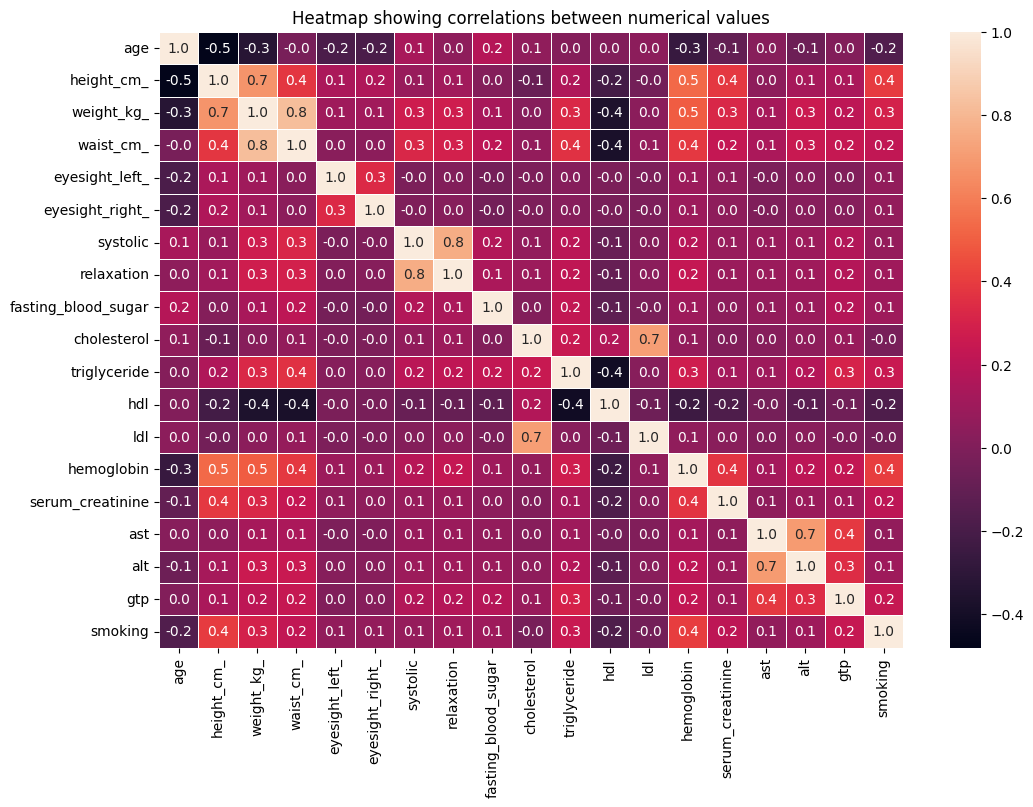

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[numerical + ["smoking"]].corr(),
    annot=True,
    fmt='.1f',
    linewidths=.5,
    xticklabels=df[numerical + ["smoking"]].columns,
    yticklabels=df[numerical + ["smoking"]].columns,
)
plt.title("Heatmap showing correlations between numerical values")
plt.show()

/var/folders/jf/hg128rzj4876fr622tw07t6c0000gp/T/ipykernel_79772/2992191942.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(color="blue", bins=80, ax=ax, layout=(3, 3), column=["hemoglobin", "age", "weight_kg_", "triglyceride"])


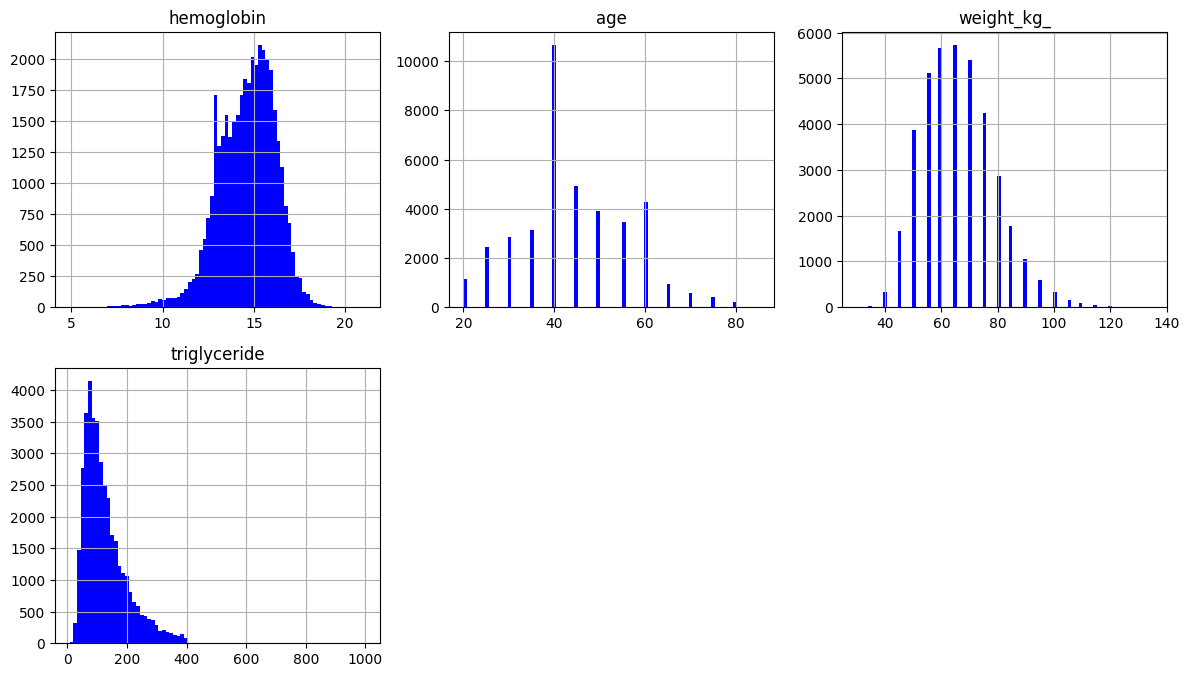

In [24]:
# We are plotting some of the numerical values to see the distributions

fig = plt.figure(figsize=(12,10))
ax = plt.gca()
df.hist(color="blue", bins=80, ax=ax, layout=(3, 3), column=["hemoglobin", "age", "weight_kg_", "triglyceride"])
plt.tight_layout()
plt.show()

In [25]:
df_hemoglobin = df[['hemoglobin', 'smoking']].copy()
df_hemoglobin['hemoglobin_r'] = df_hemoglobin['hemoglobin'].round(0)
df_hemoglobin

,hemoglobin,smoking,hemoglobin_r
0,19.8,1,20.0
1,15.9,0,16.0
2,13.7,0,14.0
3,16.9,0,17.0
4,14.9,0,15.0
...,...,...,...
38979,12.3,0,12.0
38980,12.5,0,12.0
38981,17.1,1,17.0
38982,12.0,1,12.0


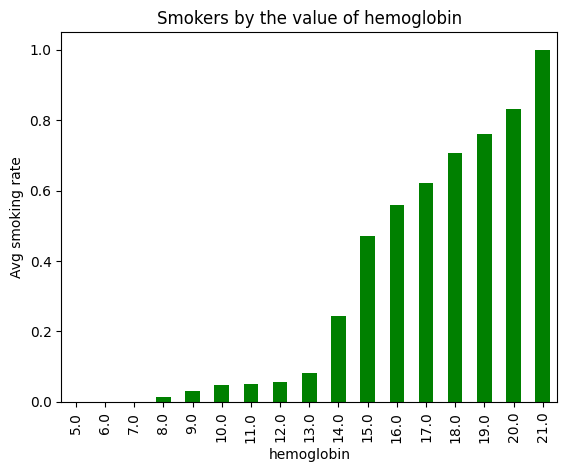

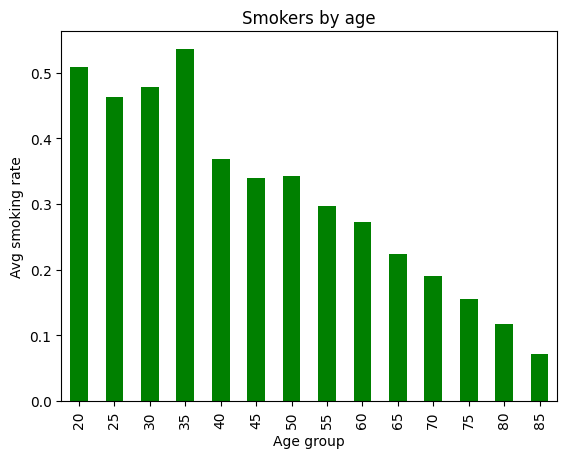

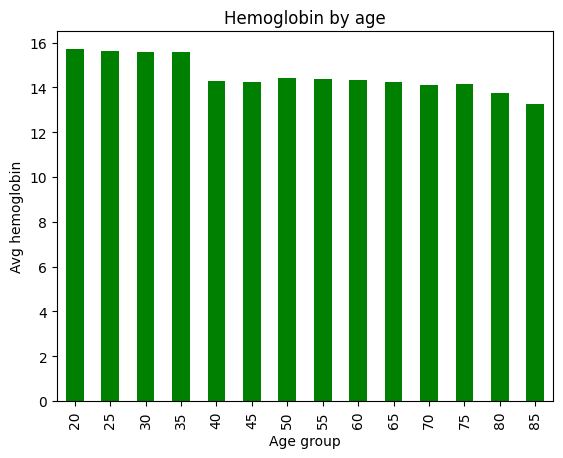

In [26]:
# Plot smoking by grouped hemoglobin values

h_plt = plt.figure(1)
h_grouped = df_hemoglobin.groupby("hemoglobin_r")["smoking"].mean()

h_grouped.plot(kind="bar", color="green")

plt.xlabel("hemoglobin")
plt.ylabel("Avg smoking rate")
plt.title("Smokers by the value of hemoglobin")


# Plot smoking by age groups
a_plt = plt.figure(2)
age_grouped = df.groupby("age")["smoking"].mean()
age_grouped.plot(kind="bar", color="green")

plt.xlabel("Age group")
plt.ylabel("Avg smoking rate")
plt.title("Smokers by age")

# Plot average hemoglobin by age groups
h__age_plt = plt.figure(3)
h_age_grouped = df.groupby("age")["hemoglobin"].mean()
h_age_grouped.plot(kind="bar", color="green")

plt.xlabel("Age group")
plt.ylabel("Avg hemoglobin")
plt.title("Hemoglobin by age")

plt.show()

## Model Taining

In [27]:
X_train = df_train
X_val = df_val

### Logistic Regression

In [28]:

model = LogisticRegression(
    solver='liblinear',
    random_state=SEED
)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]

In [30]:
auc = roc_auc_score(y_val, y_pred)
print(f"Accuracy -> {round(auc, 3)}")

Accuracy -> 0.808


In [31]:
logreg = LogisticRegression(solver='liblinear', random_state=SEED)

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
}

# Create GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 1}


In [32]:
# Get and evaluate the best model
best_model = grid_search.best_estimator_

best_predictions = best_model.predict_proba(X_val)[:, 1]
best_predictions

accuracy = roc_auc_score(y_val, best_predictions)
print(f"Best Model Accuracy: {accuracy}")

Best Model Accuracy: 0.8078265886484157


### Random Forest

In [33]:
# Create and tune Random Forest model
rf_model = RandomForestClassifier(random_state=SEED)

param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [5, 10, 20, 30],          # Maximum depth of the tree
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', verbose=3)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.820 total time=   0.8s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.814 total time=   0.8s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.809 total time=   0.7s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.806 total time=   0.6s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.808 total time=   0.7s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.821 total time=   1.4s
[CV 2/5] END .....max_depth=5, n_estimators=100;, score=0.814 total time=   1.3s
[CV 3/5] END .....max_depth=5, n_estimators=100;, score=0.808 total time=   1.3s
[CV 4/5] END .....max_depth=5, n_estimators=100;, score=0.806 total time=   1.3s
[CV 5/5] END .....max_depth=5, n_estimators=100;, score=0.809 total time=   1.3s
[CV 1/5] END .....max_depth=5, n_estimators=200;, score=0.821 total time=   2.6s
[CV 2/5] END .....max_depth=5, n_estimators=200;

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=3)

In [34]:
# Get and evaluate the best model
best_model = grid_search.best_estimator_

best_predictions = best_model.predict_proba(X_val)[:, 1]
best_predictions

accuracy = roc_auc_score(y_val, best_predictions)
print(f"Best Model Accuracy: {accuracy}")
print(f"Best params {grid_search.best_params_}")

Best Model Accuracy: 0.8879482814497719
Best params {'max_depth': 30, 'n_estimators': 200}


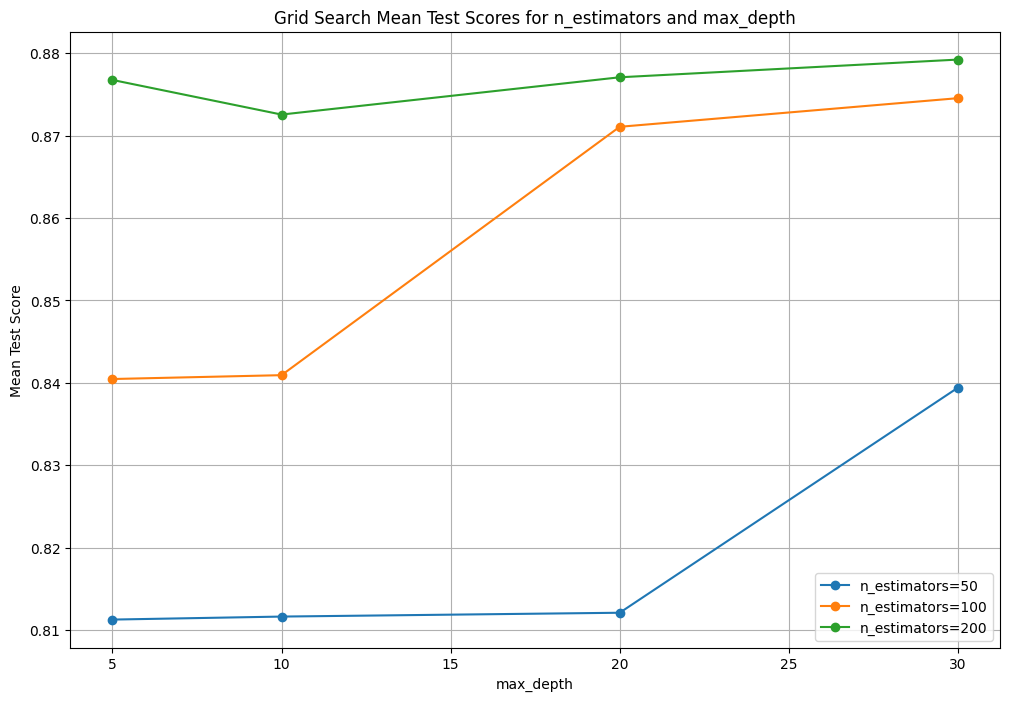

In [35]:
# Plot results of the grid search
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Reshape mean_test_scores into a 2D array
scores_matrix = np.array(mean_test_scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

# Plotting line charts
plt.figure(figsize=(12, 8))
for i, n_estimators in enumerate(param_grid['n_estimators']):
    plt.plot(param_grid['max_depth'], scores_matrix[i], label=f'n_estimators={n_estimators}', marker='o')

plt.xlabel('max_depth')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Mean Test Scores for n_estimators and max_depth')
plt.legend()
plt.grid(True)
plt.show()


### XGBoost

In [36]:
# Create and tune XGBoostClassifier
xgb_model = xgb.XGBClassifier(seed=42)

# Hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', verbose=3)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.808 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.805 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.802 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.794 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.796 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.812 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.808 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.807 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.799 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.802 to

In [37]:
# Evaluate the best model
best_model = grid_search.best_estimator_

best_predictions = best_model.predict_proba(X_val)[:, 1]
best_predictions

accuracy = roc_auc_score(y_val, best_predictions)
print(f"Best Model Accuracy: {accuracy}")
print(f"Best params {grid_search.best_params_}")

Best Model Accuracy: 0.8698391674887549
Best params {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}


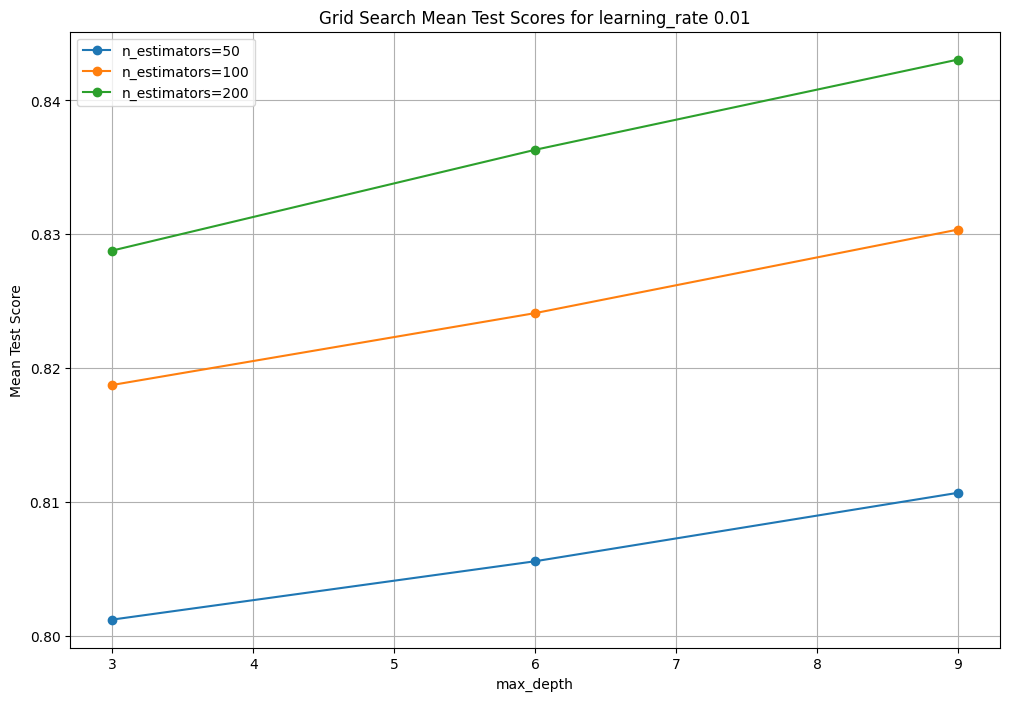

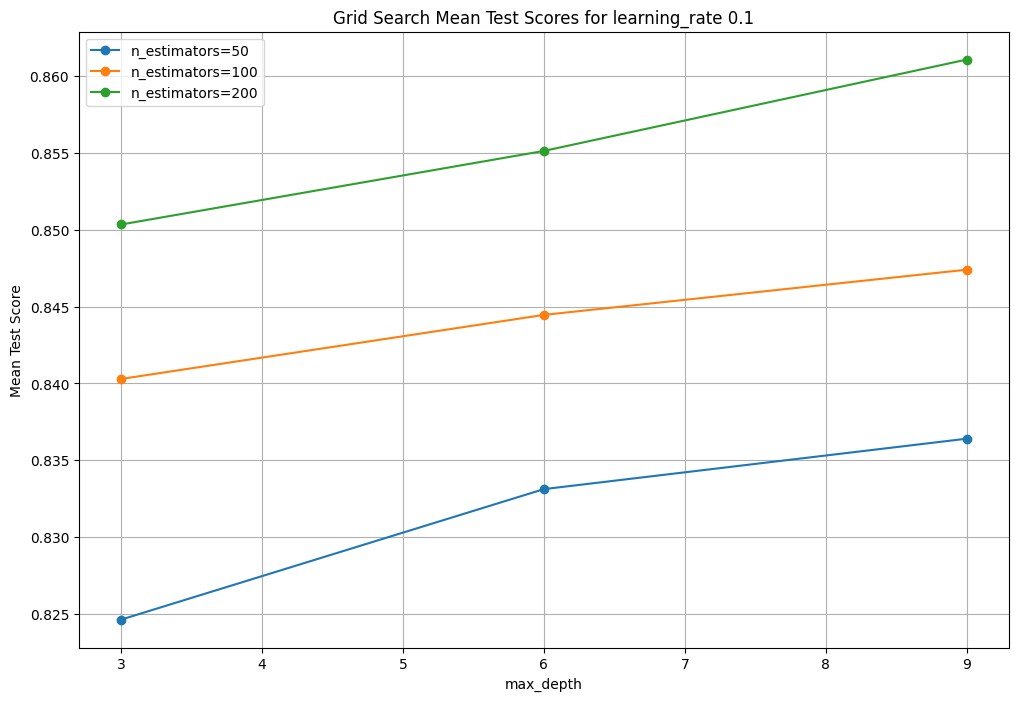

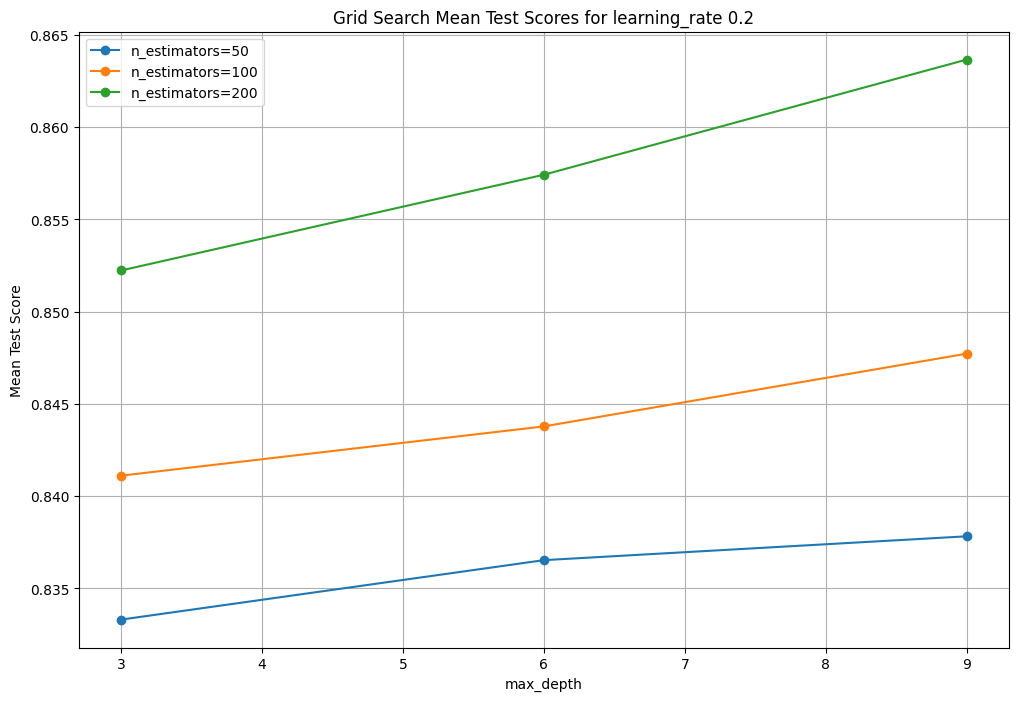

In [38]:
# Plot the results of the grid search
results = grid_search.cv_results_
param_combinations = list(zip(results['param_n_estimators'], results['param_max_depth'], results['param_learning_rate']))
mean_test_scores = results['mean_test_score']

# Reshape mean_test_scores into a 3D array
scores_tensor = np.array(mean_test_scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']), len(param_grid['learning_rate']))

# Plotting the charts
for i, learning_rate in enumerate(param_grid['learning_rate']):
    plt.figure(figsize=(12, 8))
    for j, n_estimators in enumerate(param_grid['n_estimators']):
        plt.plot(param_grid['max_depth'], scores_tensor[i,j], label=f'n_estimators={n_estimators}', marker='o')

        plt.xlabel('max_depth')
        plt.ylabel('Mean Test Score')
        plt.title(f'Grid Search Mean Test Scores for learning_rate {learning_rate}')
        plt.legend()
        plt.grid(True)
plt.show()

## Selecting the best model

The tuning has 
* Logistic Regression accuracy: 0.807
* Random Forest accuracy: 0.888
* XGBoost accuracy: 0.870

The Random Forest algorithm performed the best with **n_estimators=200** and **max_depth=30**. Interestingly, we also got almost the same accuracy using **n_estimators=100** and **max_depth=20**. Since they're quite close in accuracy, and the second set trains faster, we'll go with **n_estimators=100** and **max_depth=20**.
For the final model we'll use a bigger dataset.

### Prepare inputs

In [39]:
FEATURES = ['age',
           'height_cm_',
           'weight_kg_',
           'waist_cm_',
           'eyesight_left_',
           'eyesight_right_',
           'hearing_left_',
           'hearing_right_',
           'systolic',
           'relaxation',
           'fasting_blood_sugar',
           'cholesterol',
           'triglyceride',
           'hdl',
           'ldl',
           'hemoglobin',
           'urine_protein',
           'serum_creatinine',
           'ast',
           'alt',
           'gtp',
           'dental_caries']

In [40]:
df_full = pd.read_csv('train_big.csv')
df_full.columns = [re.sub('\W+','_',c.lower()) for c in df_full.columns]
df_full = df_full[FEATURES + ['smoking']]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height_cm_           159256 non-null  int64  
 2   weight_kg_           159256 non-null  int64  
 3   waist_cm_            159256 non-null  float64
 4   eyesight_left_       159256 non-null  float64
 5   eyesight_right_      159256 non-null  float64
 6   hearing_left_        159256 non-null  int64  
 7   hearing_right_       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting_blood_sugar  159256 non-null  int64  
 11  cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  hdl                  159256 non-null  int64  
 14  ldl                  159256 non-null  int64  
 15  hemoglobin       

In [41]:
df_full.isnull().sum()

age                    0
height_cm_             0
weight_kg_             0
waist_cm_              0
eyesight_left_         0
eyesight_right_        0
hearing_left_          0
hearing_right_         0
systolic               0
relaxation             0
fasting_blood_sugar    0
cholesterol            0
triglyceride           0
hdl                    0
ldl                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
ast                    0
alt                    0
gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [42]:
df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=SEED)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.smoking.values
y_test = df_test.smoking.values

del df_full_train['smoking']
del df_test['smoking']

In [43]:
rf_model = RandomForestClassifier(
    random_state=SEED,
    n_estimators=100,
    max_depth=20
)

rf_model.fit(df_full_train, y_full_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [44]:
y_pred = rf_model.predict_proba(df_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy -> {round(auc, 3)}")

Accuracy -> 0.855


The acuuracy is lower than with a smaller set. Let's try XGBoost on the larger set and compare the accuracies.

In [45]:
xgb_model = xgb.XGBClassifier(
    seed=SEED,
    learning_rate= 0.2, 
    max_depth=9,
    n_estimators=200
)

xgb_model.fit(df_full_train, y_full_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
y_pred = xgb_model.predict_proba(df_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy -> {round(auc, 3)}")

Accuracy -> 0.858


### Conclusion
The XGBoost shows better result on the full training set. We will chose this model and hyperparameters for the deployment.